### Preparation

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In this notebook we are trying to train a good GAN on 3D MRI of brains, following https://arxiv.org/abs/2101.07563. We use GAN instead of StyleGAN, because all of the data is made on the same equipement, so there is no need to learn style. After that, a ResNet-like encoder is trained to learn an inverse mapping to the trained generator.

### Preparing data

In [3]:
import torch.utils.data as torch_data
from torchvision.utils import save_image
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
import random
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm

In [ ]:
manualSeed = 42

random.seed(manualSeed)
torch.manual_seed(manualSeed);

In [ ]:
mri_data = np.load('tensors.npy')
age_labels = np.load('age.npy')

batch_size = 10

In [ ]:
class MRIData(torch_data.Dataset):
    def __init__(self, X, y):
        super(MRIData, self).__init__()
        self.X = X
        self.y = y
    
        data_min = self.X.min(axis=(2, 3, 4))
        data_max = self.X.max(axis=(2, 3, 4))
        data_max[data_max == 0.] = 1.
        dif = data_max - data_min

        self.X = (self.X - data_min[..., None, None, None]) / dif[..., None, None, None]

    def __len__(self):

        return len(self.X)
    
    def __getitem__(self, idx):

        return self.X[idx], self.y[idx]

In [ ]:
mri_data = np.pad(mri_data, ((0, 0), (6, 6), (0, 0), (6, 6)))
mri_data = mri_data.reshape(-1, 1, 70, 70, 70)

In [ ]:
train_dset = MRIData(mri_data, age_labels)

loader = torch_data.DataLoader(train_dset, batch_size=batch_size, shuffle=True) 

### Train simple GAN on 3D MRI data

In [ ]:
from models import Generator3D_Adaptive, Discriminator3D_Adaptive

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
Tensor = torch.cuda.FloatTensor if device == torch.device('cuda:0') else torch.FloatTensor
latent_dim = 100
n_epochs = 10

In [ ]:
import matplotlib.image as mpimg

def train_gan(threshold, n_epochs=10, latent_dim=100):
  
  G = Generator3D_Adaptive()
  D = Discriminator3D_Adaptive()

  #G.load_state_dict(torch.load('2_0.0checkpointG.pth'))
  #D.load_state_dict(torch.load('2_0.0checkpointD.pth'))

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  G.to(device);
  D.to(device);

  optimizer_G = torch.optim.Adam(G.parameters(), lr=5e-5, betas=(0.5, 0.999))
  optimizer_D = torch.optim.Adam(D.parameters(), lr=5e-5, betas=(0.5, 0.999))
  adversarial_loss = torch.nn.BCELoss()

  for epoch in range(n_epochs):

      d_losses = []
      g_losses = []

      for i, (imgs, _) in enumerate(loader):

          # Adversarial ground truths
          valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

          # Configure input
          imgs = resize(imgs, (imgs.shape[0], 1, 64, 64, 64))
          imgs = torch.tensor(imgs, dtype=torch.float32)
          real_imgs = Variable(imgs.type(Tensor))

          # -----------------
          #  Train Generator
          # -----------------

          p = np.random.rand()


          optimizer_G.zero_grad()

            # Sample noise as generator input
          z = Variable(Tensor(np.random.uniform(0, 1, (imgs.shape[0], latent_dim))))

            # Generate a batch of images
          gen_imgs = G(z)


          if p > threshold:
              
            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(D(gen_imgs), valid)
            g_losses.append(g_loss.item())
            g_loss.backward()
            optimizer_G.step()

          # ---------------------
          #  Train Discriminator
          # ---------------------

          optimizer_D.zero_grad()

          # Measure discriminator's ability to classify real from generated samples
          real_loss = adversarial_loss(D(real_imgs), valid)
          fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
          d_loss = (real_loss + fake_loss) / 2

          d_loss.backward()
          optimizer_D.step()

          batches_done = epoch * len(loader) + i

          d_losses.append(d_loss.item())

          if batches_done % 20 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(loader), np.array(d_losses).mean(), np.array(g_losses).mean())
            )

            d_losses = []
            g_losses = []

      #if epoch % 2 == 0:
          #torch.save(D.state_dict(), '/content/drive/MyDrive/GAN_project/final_checkpointD.pth')
          #torch.save(G.state_dict(), '/content/drive/MyDrive/GAN_project/final_checkpointG.pth')

          #img = gen_imgs.cpu().detach().numpy()[0, 0, 30, :, :]
          #mpimg.imsave("/content/drive/MyDrive/GAN_project/final_images/fake_img{e}.png".format(e=epoch), img)

In [ ]:
for threshold in [0.0, 0.1, 0.3]:
  train_gan(threshold=threshold)

[Epoch 0/10] [Batch 0/112] [D loss: 1.847627] [G loss: 0.025438]
[Epoch 0/10] [Batch 20/112] [D loss: 0.145859] [G loss: 2.341517]
[Epoch 0/10] [Batch 40/112] [D loss: 0.181037] [G loss: 2.929877]
[Epoch 0/10] [Batch 60/112] [D loss: 0.194085] [G loss: 2.858992]
[Epoch 0/10] [Batch 80/112] [D loss: 0.240857] [G loss: 2.553231]
[Epoch 0/10] [Batch 100/112] [D loss: 0.246352] [G loss: 2.659624]
[Epoch 1/10] [Batch 8/112] [D loss: 0.107261] [G loss: 2.346471]
[Epoch 1/10] [Batch 28/112] [D loss: 0.250807] [G loss: 2.298631]
[Epoch 1/10] [Batch 48/112] [D loss: 0.435725] [G loss: 2.081704]
[Epoch 1/10] [Batch 68/112] [D loss: 0.233728] [G loss: 2.391595]
[Epoch 1/10] [Batch 88/112] [D loss: 0.430149] [G loss: 1.619345]
[Epoch 1/10] [Batch 108/112] [D loss: 0.396962] [G loss: 1.953115]
[Epoch 2/10] [Batch 16/112] [D loss: 0.259441] [G loss: 2.192727]
[Epoch 2/10] [Batch 36/112] [D loss: 0.359329] [G loss: 2.187941]
[Epoch 2/10] [Batch 56/112] [D loss: 0.351285] [G loss: 2.208411]
[Epoch 2/1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Epoch 0/10] [Batch 0/112] [D loss: 1.845965] [G loss: nan]
[Epoch 0/10] [Batch 20/112] [D loss: 0.111762] [G loss: 2.849666]
[Epoch 0/10] [Batch 40/112] [D loss: 0.114449] [G loss: 3.768405]
[Epoch 0/10] [Batch 60/112] [D loss: 0.097501] [G loss: 3.170372]
[Epoch 0/10] [Batch 80/112] [D loss: 0.033103] [G loss: 3.658121]
[Epoch 0/10] [Batch 100/112] [D loss: 0.331809] [G loss: 3.722197]
[Epoch 1/10] [Batch 8/112] [D loss: 0.235600] [G loss: 2.136724]
[Epoch 1/10] [Batch 28/112] [D loss: 0.226762] [G loss: 2.432787]
[Epoch 1/10] [Batch 48/112] [D loss: 0.316159] [G loss: 2.729505]
[Epoch 1/10] [Batch 68/112] [D loss: 0.197095] [G loss: 2.110570]
[Epoch 1/10] [Batch 88/112] [D loss: 0.311318] [G loss: 2.456395]
[Epoch 1/10] [Batch 108/112] [D loss: 0.213526] [G loss: 2.056299]
[Epoch 2/10] [Batch 16/112] [D loss: 0.234622] [G loss: 2.561251]
[Epoch 2/10] [Batch 36/112] [D loss: 0.316901] [G loss: 3.086347]
[Epoch 2/10] [Batch 56/112] [D loss: 0.176671] [G loss: 2.550314]
[Epoch 2/10] [B

Since training a stable GAN is not an easy task, I used parameter p to control the probability, with with the optimizer of discriminator makes step, so the discriminator won't be too smart for the generator and it won't learn to generate some noise. But I don't know, which value of p whould be optimal, so I tried different, saved the corresponding models, then choosed the best one by visual estimation of the generator output, and continued to learn it.

### Creating synthetic dataset $(w_i, G(w_i))$, where w_i - random latent representation

In [ ]:
def create_synthetic_data(generator, n_samples, path_to_data, path_to_latent):
  fake_data = []
  latent_repr = []

  for i in tqdm(range(n_samples)):
     z = Variable(Tensor(np.random.uniform(0, 1, (1, latent_dim))))
     gen_imgs = generator(z).reshape(64, 64, 64)
     fake_data.append(gen_imgs.cpu().detach().numpy())
     latent_repr.append(z.cpu().detach().numpy()[0, :])

  np.save(path_to_data, np.array(fake_data))
  np.save(path_to_latent, np.array(latent_repr))
  return np.array(fake_data), np.array(latent_repr)

In [ ]:
G = Generator3D_Adaptive()
G.load_state_dict(torch.load('generator_checkpoint.pth'))
G.to(device)
G.eval();

In [5]:
fake_data, latent_repr = create_synthetic_data(G, 2000, 'fake_data.npy',
                                                'latent_repr.npy')

In [5]:
fake_data = np.load('fake_data.npy')
latent_repr = np.load('latent_repr.npy')
print(fake_data.shape, latent_repr.shape)

(2000, 64, 64, 64) (2000, 100)


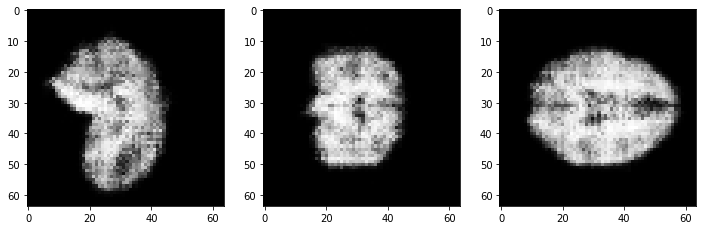

In [ ]:
import nibabel
from utils import plot_central_cuts, Fake_MRIData

plot_central_cuts(fake_data[0, ...])

### Learning autoencoder on $(w_i, G(w_i))$

In [7]:
data_train, data_val, latent_train, latent_val = train_test_split(fake_data, latent_repr,
                                                                 test_size=0.2, random_state=42)

train_dset = Fake_MRIData(data_train, latent_train)
val_dset = Fake_MRIData(data_val, latent_val)

train_loader = torch_data.DataLoader(train_dset, batch_size=5, shuffle=True)
val_loader = torch_data.DataLoader(val_dset, batch_size=5, shuffle=True) 

In [11]:
from models import Encoder

encoder = Encoder()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
encoder.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)

In [12]:
def train_encoder(encoder, criterion, opt, train_loader, val_loader, scheduler=None, n_epochs=50):

  for epoch in range(n_epochs):
    
    encoder.train()
    losses_train = []
    losses_val = []

    for X, latent_repr in train_loader:
      X, latent_repr = X.to(device), latent_repr.to(device)

      optimizer.zero_grad()
      output = encoder(X)
      loss = criterion(latent_repr, output)
      losses_train.append(loss.detach().cpu().numpy())

      loss.backward()
      optimizer.step()

    encoder.eval()
    for X, latent_repr in val_loader:

      X, latent_repr = X.to(device), latent_repr.to(device)
      output = encoder(X)
      loss = criterion(latent_repr, output)
      losses_val.append(loss.detach().cpu().numpy())

    if scheduler is not None:
      scheduler.step()

    if epoch % 1 == 0:
      mean_val = sum(losses_val)/len(losses_val)
      mean_train = sum(losses_train)/len(losses_train)

      print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'\
                  .format(epoch, n_epochs, mean_train, mean_val))
      
      #torch.save(encoder.state_dict(), '/content/drive/MyDrive/GAN_project/encoder_checkpoint.pth')

In [13]:
train_encoder(encoder, criterion, optimizer, train_loader, val_loader)

Epoch 0/50 || Loss:  Train 0.1379 | Validation 0.0906
Epoch 1/50 || Loss:  Train 0.0903 | Validation 0.0880
Epoch 2/50 || Loss:  Train 0.0880 | Validation 0.0880
Epoch 3/50 || Loss:  Train 0.0869 | Validation 0.0874
Epoch 4/50 || Loss:  Train 0.0866 | Validation 0.0870
Epoch 5/50 || Loss:  Train 0.0864 | Validation 0.0867
Epoch 6/50 || Loss:  Train 0.0859 | Validation 0.0860
Epoch 7/50 || Loss:  Train 0.0852 | Validation 0.0844
Epoch 8/50 || Loss:  Train 0.0846 | Validation 0.0861
Epoch 9/50 || Loss:  Train 0.0836 | Validation 0.0826
Epoch 10/50 || Loss:  Train 0.0825 | Validation 0.0810
Epoch 11/50 || Loss:  Train 0.0805 | Validation 0.0795
Epoch 12/50 || Loss:  Train 0.0780 | Validation 0.0764
Epoch 13/50 || Loss:  Train 0.0736 | Validation 0.0747
Epoch 14/50 || Loss:  Train 0.0671 | Validation 0.0665
Epoch 15/50 || Loss:  Train 0.0555 | Validation 0.0525
Epoch 16/50 || Loss:  Train 0.0380 | Validation 0.0333
Epoch 17/50 || Loss:  Train 0.0204 | Validation 0.0171
Epoch 18/50 || Loss: